In [ ]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-10-02 10:21:00--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75257002 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  71.77M   222MB/s    in 0.3s    

2019-10-02 10:21:00 (222 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [75257002/75257002]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-package-ha

In [ ]:
#Read smiles files
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
print (len(smiles))
print (smiles[0])

482852
O=[N+]([O-])c1ccc(O)c(/C=N/c2ccc3nccnc3c2)c1


In [ ]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import torch
import time

X, Y = [], []
num_data = 20000
st = time.time()
for s in smiles[:num_data]:
  m = Chem.MolFromSmiles(s)
  fp = np.array(AllChem.GetMorganFingerprintAsBitVect(m,2, nBits=1024))
  logp = MolLogP(m)
  X.append(fp)
  Y.append(logp)
end = time.time()

#Convert to torch tensor
X = torch.from_numpy(np.array(X)).float()
Y = torch.from_numpy(np.array(Y)).float()

print (X.size())
print (Y.size())
print (f'Time:{(end-st):.3f}')

torch.Size([20000, 1024])
torch.Size([20000])
Time:44.592


In [ ]:
#Divide training and test data
num_train = 19000
X_train = X[:num_train]
Y_train = Y[:num_train]
X_test = X[num_train:]
Y_test = Y[num_train:]

# num_test = 1000
# X_train = []
# Y_train = []
# X_test = []
# Y_test = []

# for i in range(int(num_data/num_test)):
#   X_train.append(X[:i*num_data] + X[(i+1)*num_test:])
#   Y_train.append(Y[:i*num_data] + Y[(i+1)*num_test:])
#   X_test.append(X[i*num_test : (i+1)*num_test])
#   Y_test.append(Y[i*num_test : (i+1)*num_test])

print (f'Num train data: {len(X_train)}')
print (f'Num test data: {len(X_test)}')


Num train data: 19000
Num test data: 1000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#linear
class LinearRegressor(torch.nn.Module):
  def __init__(self, D_in, D_out):
    super(LinearRegressor, self).__init__()
    self.linear = torch.nn.Linear(D_in, D_out)

  def forward(self, x):
    retval = self.linear(x)
    return retval

#tanh
class NonLinearRegressor_tanh(torch.nn.Module):
  def __init__(self, D_in, D_out, H):
    super(NonLinearRegressor_tanh, self).__init__()
    #blank
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, D_out)
    

  def forward(self, x):
    #blank
    retval = self.linear1(x)
    retval = F.tanh(retval)
    retval = self.linear2(retval)
    retval = F.tanh(retval)
    retval = self.linear3(retval)
    return retval

#ReLU
class NonLinearRegressor_ReLU(torch.nn.Module):
  def __init__(self, D_in, D_out, H):
    super(NonLinearRegressor_ReLU, self).__init__()
    #blank
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, D_out)

    
  def forward(self, x):
    #blank
    retval = self.linear1(x)
    retval = F.relu(retval)
    retval = self.linear2(retval)
    retval = F.relu(retval)
    retval = self.linear3(retval)
    return retval

#tanh with 5 layer
class NonLinearRegressor_tanh_5(torch.nn.Module):
  def __init__(self, D_in, D_out, H):
    super(NonLinearRegressor_tanh_5, self).__init__()
    #blank
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, H)
    self.linear4 = nn.Linear(H, H)
    self.linear5 = nn.Linear(H, H)
    self.linear6 = nn.Linear(H, H)
    self.linear7 = nn.Linear(H, H)
    self.linear8 = nn.Linear(H, H)
    self.linear9 = nn.Linear(H, H)
    self.linear10 = nn.Linear(H, D_out)
  
  def forward(self, x):
    #blank
    retval = self.linear1(x)
    retval = F.tanh(retval)
    retval = self.linear2(retval)
    retval = F.tanh(retval)
    retval = self.linear3(retval)
    retval = F.tanh(retval)
    retval = self.linear4(retval)
    retval = F.tanh(retval)
    retval = self.linear5(retval)
    retval = F.tanh(retval)
    retval = self.linear6(retval)
    retval = F.tanh(retval)
    retval = self.linear7(retval)
    retval = F.tanh(retval)
    retval = self.linear8(retval)
    retval = F.tanh(retval)
    retval = self.linear9(retval)
    retval = F.tanh(retval)
    retval = self.linear10(retval) 
    return retval

#ReLU with 5 layer
class NonLinearRegressor_ReLU_5(torch.nn.Module):
  def __init__(self, D_in, D_out, H):
    super(NonLinearRegressor_ReLU_5, self).__init__()
    #blank
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, H)
    self.linear4 = nn.Linear(H, H)
    self.linear5 = nn.Linear(H, H)
    self.linear6 = nn.Linear(H, H)
    self.linear7 = nn.Linear(H, H)
    self.linear8 = nn.Linear(H, H)
    self.linear9 = nn.Linear(H, H)
    self.linear10 = nn.Linear(H, D_out)
    
  def forward(self, x):
    #blank
    retval = self.linear1(x)
    retval = F.relu(retval)
    retval = self.linear2(retval)
    retval = F.relu(retval)
    retval = self.linear3(retval)
    retval = F.relu(retval)
    retval = self.linear4(retval)
    retval = F.relu(retval)
    retval = self.linear5(retval) 
    retval = F.relu(retval)
    retval = self.linear6(retval)
    retval = F.relu(retval)
    retval = self.linear7(retval)
    retval = F.relu(retval)
    retval = self.linear8(retval)
    retval = F.relu(retval)
    retval = self.linear9(retval)
    retval = F.relu(retval)
    retval = self.linear10(retval) 
    return retval

In [ ]:
#Train model
import time
lr = 1e-6

model = LinearRegressor(1024, 1)
model_tanh = NonLinearRegressor_tanh(1024, 1, 1024)
model_ReLU = NonLinearRegressor_ReLU(1024, 1, 1024)
model_tanh_5 = NonLinearRegressor_tanh_5(1024, 1, 1024)
model_ReLU_5 = NonLinearRegressor_ReLU_5(1024, 1, 1024)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=lr)
optimizer_ReLU = torch.optim.Adam(model_ReLU.parameters(), lr=lr)
optimizer_tanh_5 = torch.optim.Adam(model_tanh_5.parameters(), lr=lr)
optimizer_ReLU_5 = torch.optim.Adam(model_ReLU_5.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()
batch_size = 512

loss_list = []
loss_list_tanh = []
loss_list_ReLU = []
loss_list_tanh_5 = []
loss_list_ReLU_5 = []

st = time.time()

X_train = X_train.cuda()
Y_train = Y_train.cuda()
X_test = X_test.cuda()
Y_test = Y_test.cuda()

modle = model.cuda()
model_tanh = model_tanh.cuda()
model_ReLU = model_ReLU.cuda()
model_tanh_5 = model_tanh_5.cuda()
model_ReLU_5 = model_ReLU_5.cuda()

for i in range(50001):
  # #blank
  idx = torch.randint(0, len(X_train), (batch_size,))
  x = X_train[idx, :]
  y = Y_train[idx]

  # #linear
  # pred = model(x)
  # pred = pred.squeeze(-1)
  # loss = loss_fn(pred, y)
  # loss.backward()
  # optimizer.step()
  # loss_list.append(loss.data.cpu().numpy())

  # #tanh
  # pred_tanh = model_tanh(x)
  # pred_tanh = pred_tanh.squeeze(-1)
  # loss_tanh = loss_fn(pred_tanh, y)
  # loss_tanh.backward()
  # optimizer_tanh.step()
  # loss_list_tanh.append(loss_tanh.data.cpu().numpy())

  # #ReLU
  # pred_ReLU = model_ReLU(x)
  # pred_ReLU = pred_ReLU.squeeze(-1)
  # loss_ReLU = loss_fn(pred_ReLU, y)
  # loss_ReLU.backward()
  # optimizer_ReLU.step()
  # loss_list_ReLU.append(loss_ReLU.data.cpu().numpy())

  #tanh with 5 layer
  pred_tanh_5 = model_tanh_5(x)
  pred_tanh_5 = pred_tanh_5.squeeze(-1)
  loss_tanh_5 = loss_fn(pred_tanh_5, y)
  loss_tanh_5.backward()
  optimizer_tanh_5.step()
  loss_list_tanh_5.append(loss_tanh_5.data.cpu().numpy())

  #ReLU with 5 layer
  pred_ReLU_5 = model_ReLU_5(x)
  pred_ReLU_5 = pred_ReLU_5.squeeze(-1)
  loss_ReLU_5 = loss_fn(pred_ReLU_5, y)
  loss_ReLU_5.backward()
  optimizer_ReLU_5.step()
  loss_list_ReLU_5.append(loss_ReLU_5.data.cpu().numpy())


  if i%1000==0:
    #print (i, loss.data.cpu().numpy(), loss_tanh.data.cpu().numpy(), loss_ReLU.data.cpu().numpy(), loss_tanh_5.data.cpu().numpy(), loss_ReLU_5.data.cpu().numpy())
    print (i, loss_tanh_5.data.cpu().numpy(), loss_ReLU_5.data.cpu().numpy())

end = time.time()
print ('Time:', end-st)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 14.676385 14.818475
1000 2.7029867 3.760413
2000 2.2957647 4.6004457
3000 2.1087875 1.4843045
4000 2.1280534 2.0177011
5000 1.4164932 1.3643212
6000 1.0613282 1.7449957
7000 1.261325 2.6111774
8000 1.0601382 1.9108776
9000 0.97809637 1.2634404
10000 1.3033502 1.6552895
11000 1.6495541 1.0262021
12000 1.0123543 1.3386978
13000 1.2446585 0.9165406
14000 0.8358075 1.0544916
15000 0.82266974 0.7317048
16000 0.91544807 0.8764207
17000 0.7260878 0.75129294
18000 0.7904345 0.8774244
19000 0.6740236 0.57038134
20000 0.6737697 0.51915544
21000 0.6498378 0.579494
22000 0.55098367 0.38849878
23000 0.59574735 0.44705433
24000 0.6245321 0.5631009
25000 0.58859134 0.45676824
26000 0.6729212 0.47475263
27000 0.5486328 0.3369678
28000 0.5905249 0.30373597
29000 0.60021734 0.26383016
30000 0.6150672 0.26018247
31000 0.5895895 0.33019072
32000 0.5956086 0.20114067
33000 0.52068996 0.28647497
34000 0.58245796 0.38975966
35000 0.510878 0.34901518
36000 0.46845913 0.27871418
37000 0.57740813 0.17952171
3

In [ ]:
# # #Save model
# fn1 = '/content/gdrive/My Drive/save.pt'
# torch.save(model.state_dict(), fn1)
# fn2 = '/content/gdrive/My Drive/save_tanh.pt'
# torch.save(model_tanh.state_dict(), fn2)
# fn3 = '/content/gdrive/My Drive/save_relu.pt'
# torch.save(model_ReLU.state_dict(), fn3)
# fn4 = '/content/gdrive/My Drive/save_tanh_5.pt'
# torch.save(model_tanh_5.state_dict(), fn4)
# fn5 = '/content/gdrive/My Drive/save_relu_5.pt'
# torch.save(model_ReLU_5.state_dict(), fn5)


# #Load model
# model.load_state_dict(torch.load(fn))

Text(0.5, 0, 'Num iteration')

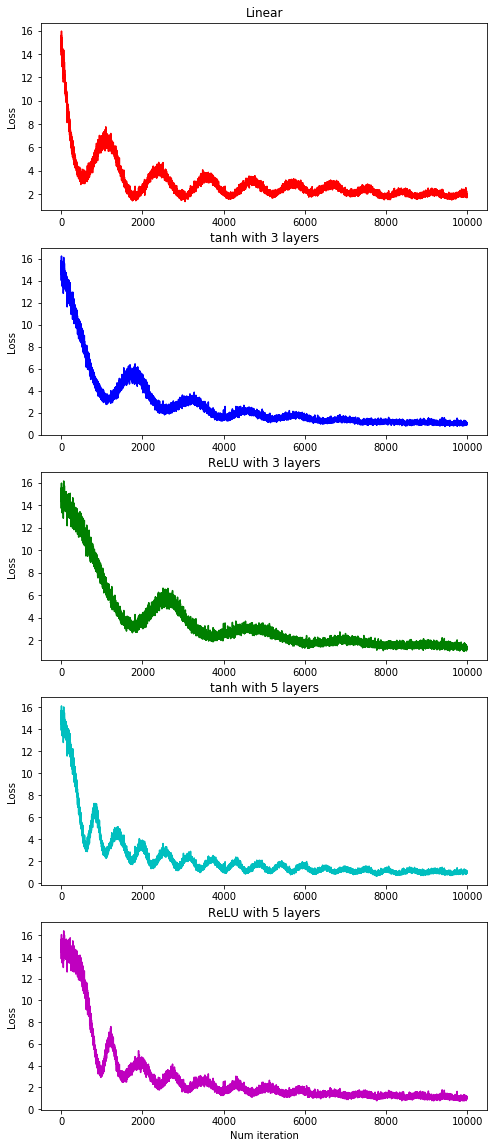

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 20))
# plt.subplot(5, 1, 1)
# plt.plot(loss_list[:10000], 'r')
# plt.title('Linear')
# plt.ylabel('Loss')

# plt.subplot(5, 1, 2)
# plt.plot(loss_list_tanh[:10000], 'b')
# plt.title('tanh with 3 layers')
# plt.ylabel('Loss')

# plt.subplot(5, 1, 3)
# plt.plot(loss_list_ReLU[:10000], 'g')
# plt.title('ReLU with 3 layers')
# plt.ylabel('Loss')

# plt.subplot(5, 1, 4)
# plt.plot(loss_list_tanh_5[:10000], 'c')
# plt.title('tanh with 5 layers')
# plt.ylabel('Loss')

# plt.subplot(5, 1, 5)
# plt.plot(loss_list_ReLU_5[:10000], 'm')
# plt.title('ReLU with 5 layers')
# plt.ylabel('Loss')
# plt.xlabel('Num iteration')


In [ ]:
#Test model
model.eval()
with torch.no_grad():
  # y_pred_train = model(X_train).squeeze(-1)
  # y_pred_test = model(X_test).squeeze(-1)

  # y_pred_train_tanh = model_tanh(X_train).squeeze(-1)
  # y_pred_test_tanh = model_tanh(X_test).squeeze(-1)

  # y_pred_train_ReLU = model_ReLU(X_train).squeeze(-1)
  # y_pred_test_ReLU = model_ReLU(X_test).squeeze(-1)

  y_pred_train_tanh_5 = model_tanh_5(X_train).squeeze(-1)
  y_pred_test_tanh_5 = model_tanh_5(X_test).squeeze(-1)

  y_pred_train_ReLU_5 = model_ReLU_5(X_train).squeeze(-1)
  y_pred_test_ReLU_5 = model_ReLU_5(X_test).squeeze(-1)


# loss_train = loss_fn(Y_train, y_pred_train)
# loss_test = loss_fn(Y_test, y_pred_test)

# loss_train_tanh = loss_fn(Y_train, y_pred_train_tanh)
# loss_test_tanh = loss_fn(Y_test, y_pred_test_tanh)

# loss_train_ReLU = loss_fn(Y_train, y_pred_train_ReLU)
# loss_test_ReLU = loss_fn(Y_test, y_pred_test_ReLU)

loss_train_tanh_5 = loss_fn(Y_train, y_pred_train_tanh_5)
loss_test_tanh_5 = loss_fn(Y_test, y_pred_test_tanh_5)

loss_train_ReLU_5 = loss_fn(Y_train, y_pred_train_ReLU_5)
loss_test_ReLU_5 = loss_fn(Y_test, y_pred_test_ReLU_5)

# print ('Train loss:', loss_train.data.cpu().numpy(), loss_train_tanh.data.cpu().numpy(), loss_train_ReLU.data.cpu().numpy(), loss_train_tanh_5.data.cpu().numpy(), loss_train_ReLU_5.data.cpu().numpy())
# print ('Test loss:', loss_test.data.cpu().numpy(), loss_test_tanh.data.cpu().numpy(), loss_test_ReLU.data.cpu().numpy(), loss_test_tanh_5.data.cpu().numpy(), loss_test_ReLU_5.data.cpu().numpy())

print ('Train loss:',  loss_train_tanh_5.data.cpu().numpy(), loss_train_ReLU_5.data.cpu().numpy())
print ('Test loss:', loss_test_tanh_5.data.cpu().numpy(), loss_test_ReLU_5.data.cpu().numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train loss: 0.42425147 0.09284364
Test loss: 0.7681349 0.43791625


Text(0, 0.5, 'Pred')

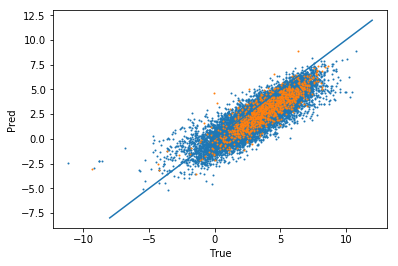

In [ ]:
plt.scatter(Y_train.data.cpu().numpy(), y_pred_train.data.cpu().numpy(), s=1)
plt.scatter(Y_test.data.cpu().numpy(), y_pred_test.data.cpu().numpy(), s=1)
plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
